# Курсовая работа
*в рамках курса "Теория вероятностей и математическая статистика" (27 апреля 2019) на площадке geekbrains.ru*

__Тема__: Предиктивная аналитика дохода от фильма в разрезе жанра.  
__Автор__: Кабанов Сергей (me.fargot@ya.ru)

Целью данной курсовой работы являюется применение на практике знаний полученных в рамках курса. В данной курсовой работе предпринимается попытка описать доходы фильмов исключительно по его жанру в разные года, а так же построить модель для оценки такого дохода в будущем.

В качестве источника данных был взят dataset с kaggle "TMDB 5000 Movie Dataset": https://www.kaggle.com/tmdb/tmdb-movie-metadata 

Из данного датасета работа велась только с данными из файла ``tmdb_5000_movies.csv``

План работы:

1. Подготовить данные для решения поставленной задачи: выделить необходимые столбцы, очистить данные.
2. Разбить данные по жанрам. Создать для каждого жанра свой отдельный набор данных, где параметром будет год, а целевым параметром будет отношение средней прибыли за фильмы (разница между бюджетом и сборами) к общей прибыли за год по всем жанрам.
3. Построить соответствующие графики
4. Построить модель линейной регрессии
5. Сделать предсказание для каждого класса жанров на 2020 год.

#### Загрузка данных

In [1]:
import pandas as pd

DATA_FILE_NAME = 'tmdb_5000_movies.csv'

orig_data = pd.read_csv(DATA_FILE_NAME, parse_dates=['release_date'])

#### 1. Подготовка данных

In [2]:
orig_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4803 entries, 0 to 4802
Data columns (total 20 columns):
budget                  4803 non-null int64
genres                  4803 non-null object
homepage                1712 non-null object
id                      4803 non-null int64
keywords                4803 non-null object
original_language       4803 non-null object
original_title          4803 non-null object
overview                4800 non-null object
popularity              4803 non-null float64
production_companies    4803 non-null object
production_countries    4803 non-null object
release_date            4802 non-null datetime64[ns]
revenue                 4803 non-null int64
runtime                 4801 non-null float64
spoken_languages        4803 non-null object
status                  4803 non-null object
tagline                 3959 non-null object
title                   4803 non-null object
vote_average            4803 non-null float64
vote_count              4803 n

Из всего списка столбцов нам необходимы только budget, genres, release_date, revenue. Так же оставим такие поля как id и title, если потребуются дополнительные данные для какого-то конкретного фильма.

In [3]:
columns = ['id', 'title', 'release_date', 'genres', 'budget',  'revenue']

data = orig_data[columns]

Одного значения в release_date не хватает. Исправляем ситуацию.

In [4]:
data = data.dropna()

data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4802 entries, 0 to 4802
Data columns (total 6 columns):
id              4802 non-null int64
title           4802 non-null object
release_date    4802 non-null datetime64[ns]
genres          4802 non-null object
budget          4802 non-null int64
revenue         4802 non-null int64
dtypes: datetime64[ns](1), int64(3), object(2)
memory usage: 262.6+ KB


In [5]:
data.describe()

,id,budget,revenue
count,4802.000000,4.802000e+03,4.802000e+03
mean,57098.234902,2.905109e+07,8.227777e+07
std,88581.302370,4.072447e+07,1.628697e+08
min,5.000000,0.000000e+00,0.000000e+00
25%,9013.750000,8.000000e+05,0.000000e+00
50%,14626.500000,1.500000e+07,1.917498e+07
75%,58589.750000,4.000000e+07,9.291920e+07
max,459488.000000,3.800000e+08,2.787965e+09


Видим, что есть фильмы с нулевым бюджетом и доходом. Убираем такие фильмы.

In [8]:
data = data[(data['budget'] != 0) & (data['revenue'] != 0)]

Сразу посчитаем поле profit как разницу между budget и revenue

In [9]:
data['profit'] = data['revenue'] - data['budget']

Выделим год в отдельный столбец

In [10]:
data['year'] = data['release_date'].dt.year

data = data.drop(columns='release_date')

Посмотрим на столбце genres

In [11]:
data['genres'].head()

0    [{"id": 28, "name": "Action"}, {"id": 12, "nam...
1    [{"id": 12, "name": "Adventure"}, {"id": 14, "...
2    [{"id": 28, "name": "Action"}, {"id": 12, "nam...
3    [{"id": 28, "name": "Action"}, {"id": 80, "nam...
4    [{"id": 28, "name": "Action"}, {"id": 12, "nam...
Name: genres, dtype: object

Видно, что данные представленны в виде json. Необходимо преобразовать эти данные в строку из жанров с разделителем.

In [12]:
import json

In [13]:
def genre_string(genres, sep):
    genre_json = json.loads(genres.replace("'", '"'))
    genre_list = [el['name'] for el in genre_json]
    genre_list.sort()
    return sep.join(genre_list)

In [14]:
data['genres'] = data['genres'].apply(genre_string, args=('|'))

In [15]:
data['genres'].head()

0    Action|Adventure|Fantasy|Science Fiction
1                    Action|Adventure|Fantasy
2                      Action|Adventure|Crime
3                 Action|Crime|Drama|Thriller
4            Action|Adventure|Science Fiction
Name: genres, dtype: object

Данные готовы для последующей работы

In [16]:
data.head()

,id,title,genres,budget,revenue,profit,year
0,19995,Avatar,Action|Adventure|Fantasy|Science Fiction,237000000,2787965087,2550965087,2009
1,285,Pirates of the Caribbean: At World's End,Action|Adventure|Fantasy,300000000,961000000,661000000,2007
2,206647,Spectre,Action|Adventure|Crime,245000000,880674609,635674609,2015
3,49026,The Dark Knight Rises,Action|Crime|Drama|Thriller,250000000,1084939099,834939099,2012
4,49529,John Carter,Action|Adventure|Science Fiction,260000000,284139100,24139100,2012


In [17]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3229 entries, 0 to 4798
Data columns (total 7 columns):
id         3229 non-null int64
title      3229 non-null object
genres     3229 non-null object
budget     3229 non-null int64
revenue    3229 non-null int64
profit     3229 non-null int64
year       3229 non-null int64
dtypes: int64(5), object(2)
memory usage: 201.8+ KB


#### 2. Разбиение по жанрам

In [18]:
(data['genres'] == '').any()

True

Видим, что есть фильмы без жанра, убираем их.

In [20]:
data = data[data['genres'] != '']

Найдем множество жанров встречающихся в данных

In [21]:
genres = data['genres']

In [22]:
genres_set = set()
for genre_str in genres:
    for genre in genre_str.split('|'):
        genres_set.add(genre)

In [23]:
genres_set

{'Action',
 'Adventure',
 'Animation',
 'Comedy',
 'Crime',
 'Documentary',
 'Drama',
 'Family',
 'Fantasy',
 'Foreign',
 'History',
 'Horror',
 'Music',
 'Mystery',
 'Romance',
 'Science Fiction',
 'Thriller',
 'War',
 'Western'}

Создадим дополнительные столбцы принадлежности к жанру.

In [30]:
for genre in genres_set:
    data[genre] = data['genres'].str.contains(genre)

Посмотрим на количество выпускаемых фильмов по годам

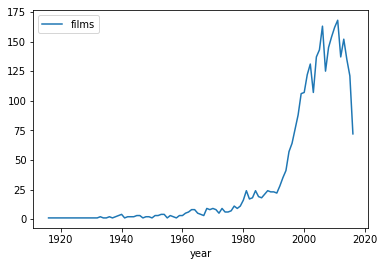

In [49]:
data.loc[:, ['profit', 'year']].groupby(by='year').count().rename(columns={'profit': 'films'}).plot();

Для дальнейшего анализа возьмем только те фильмы, которые были выпущены после 2000 года и до 2016. Т.к. до этого времени фильмов слишком мало. А в 2016 похоже учтены не все фильмы.

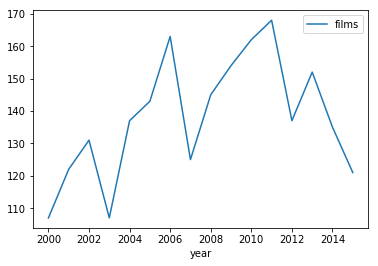

In [63]:
data.loc[:, ['profit', 'year']].groupby(by='year').count().rename(columns={'profit': 'films'}).loc[2000:2015].plot();

In [67]:
data = data[data['year'].between(left=2000, right=2015)]

#### 3. Построение графиков и анализ данных

Посчитаем общий доход по годам по всем жанрам:

In [78]:
profit_sum = data.loc[:, ['profit', 'year']].groupby(by='year').sum()

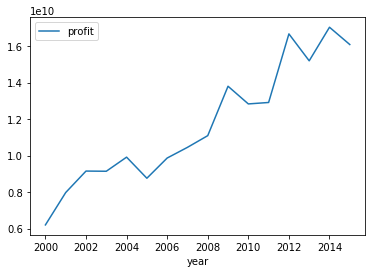

In [79]:
profit_sum.plot();

Посчитаем доход в жанре Action

In [80]:
action_sum = data.loc[data['Action'], ['profit', 'year']].groupby(by='year').sum()

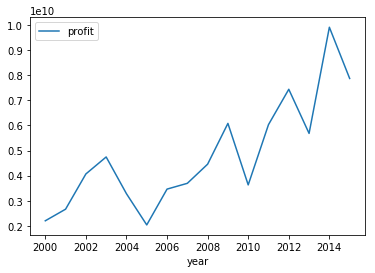

In [81]:
action_sum.plot();

Посчитаем отношение дохода в жанре Action к общему доходу

In [82]:
action_perc = action_sum / profit_sum

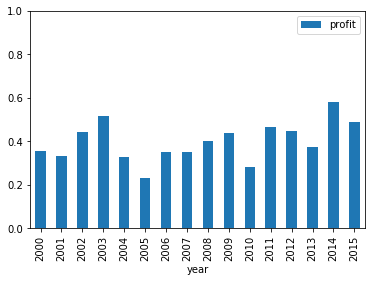

In [88]:
action_perc.plot(kind='bar', ylim=(0,1));

Построим графики для всех жанров

In [89]:
import matplotlib.pyplot as plt

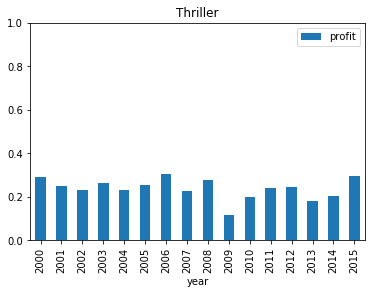

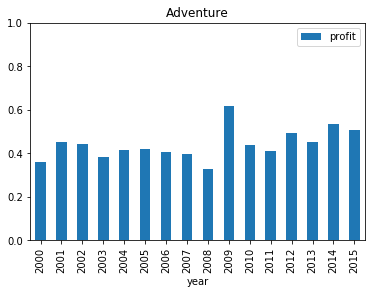

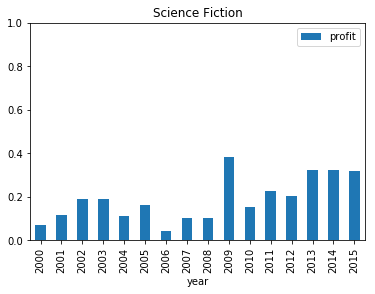

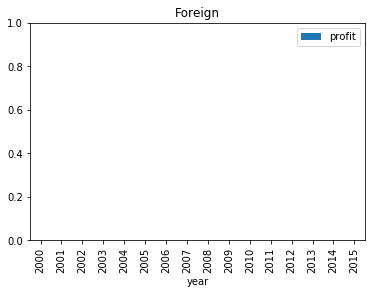

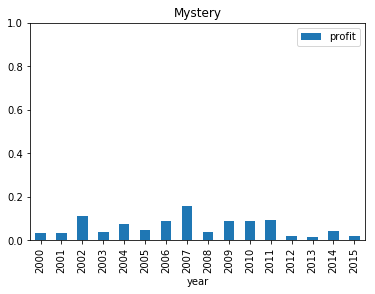

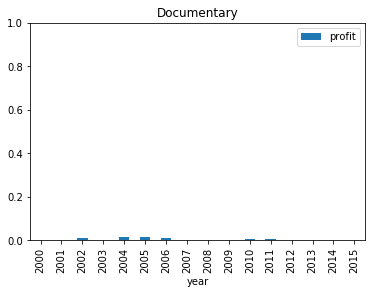

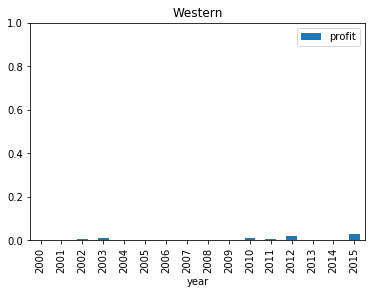

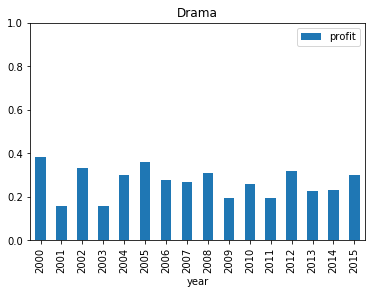

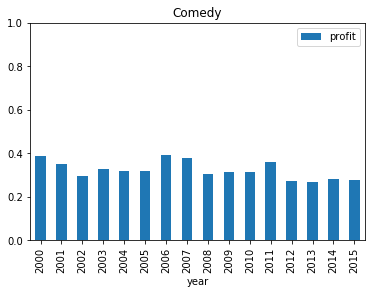

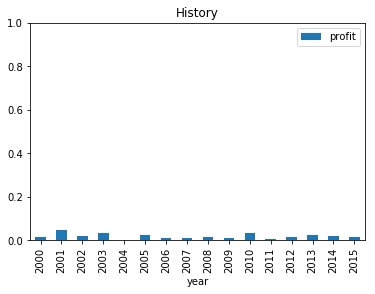

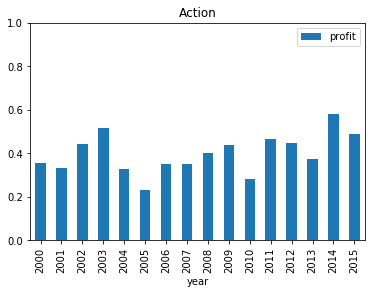

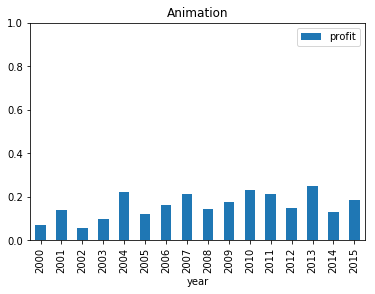

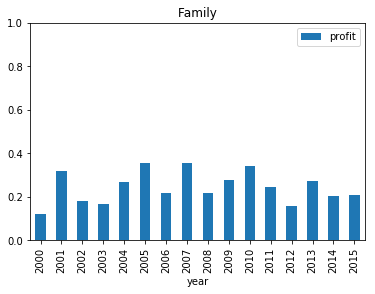

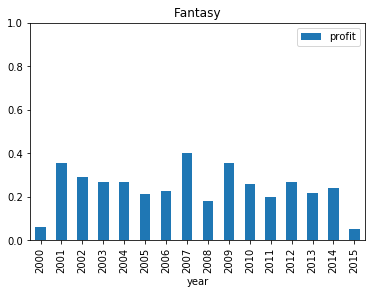

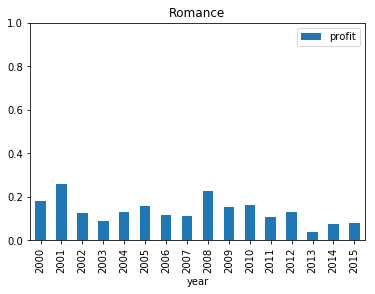

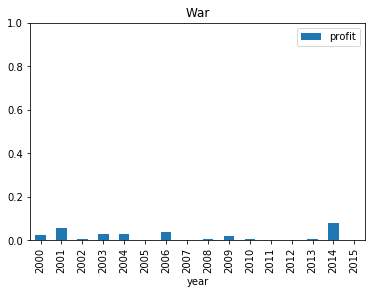

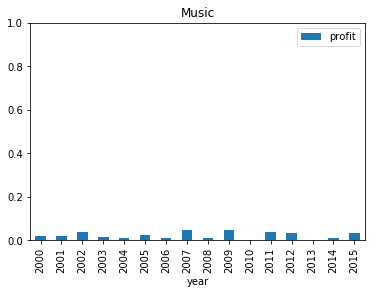

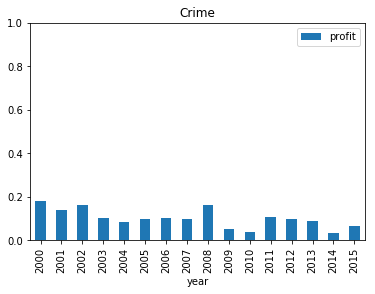

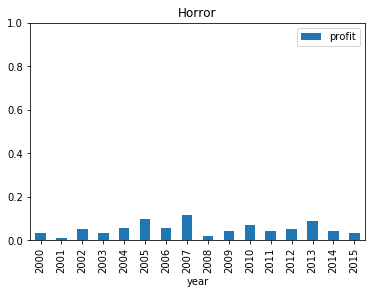

In [91]:
for genre in genres_set:
    genre_sum = data.loc[data[genre], ['profit', 'year']].groupby(by='year').sum()
    genre_perc = genre_sum / profit_sum
    genre_perc.plot(kind='bar', ylim=(0,1))
    plt.title(genre)
    plt.show();

Визуально выделем более-менее значимые жанры для дальнейшего построения моделей:

``Thriller``
``Adventure``
``Science Fiction``
``Drama``
``Comedy``
``Action``
``Animation``
``Family``
``Fantasy``
``Romance``
``Crime``
``Horror``



In [111]:
genres_list = ['Thriller', 'Adventure', 'Science Fiction', 'Drama', 'Comedy',
               'Action', 'Animation', 'Family', 'Fantasy', 'Romance', 'Crime', 'Horror']

#### 4. Построение модели линейной регрессии

Построим модель линейной регрессии для жанра Adventure

In [94]:
import numpy as np

In [100]:
def get_genre_data(genre):
    ''' Возвращает DataFrame по жанру genre с долей дохода в общегодовом доходе
    '''
    genre_sum = data.loc[data[genre], ['profit', 'year']].groupby(by='year').sum()
    genre_perc = genre_sum / profit_sum
    return genre_perc

In [138]:
genre = genres_list[1]
genre

'Adventure'

In [139]:
df = get_genre_data(genre)

In [140]:
x = np.array(df.index - 2000)  # для того, чтобы x начинался с нуля
y = np.array(df.values)

Воспользуемся формулами для нахождения коэфициентов парной регрессии

In [141]:
b1 = (np.mean(y * x) - np.mean(y) * np.mean(x)) / (np.mean(x ** 2) - np.mean(x) ** 2)
b0 = np.mean(y) - b1 * np.mean(x)

b1, b0

(0.0, 0.4415526520931443)

Как видим, наше уравнение не зависит от $x$, т.к. коэф. $b_1$ практически равен 0 и имеет вид:
$$y = 0.442$$

Найдем коэфициенты парной регресси для всех жанров

In [109]:
def get_b0_b1(x, y):
    b1 = (np.mean(y * x) - np.mean(y) * np.mean(x)) / (np.mean(x ** 2) - np.mean(x) ** 2)
    b0 = np.mean(y) - b1 * np.mean(x)
    return (b0, b1)

In [137]:
for genre in genres_list:
    df = get_genre_data(genre)
    x = np.array(df.index - 2000)
    y = np.array(df.values)
    b0, b1 = get_b0_b1(x, y)
    print(f'Коэф. парной регрессии для жанра {genre}:\nb0 = {np.round(b0, 3)},\tb1={np.round(b1, 3)}\n')

Коэф. парной регрессии для жанра Thriller:
b0 = 0.239,	b1=0.0

Коэф. парной регрессии для жанра Adventure:
b0 = 0.442,	b1=0.0

Коэф. парной регрессии для жанра Science Fiction:
b0 = 0.189,	b1=0.0

Коэф. парной регрессии для жанра Drama:
b0 = 0.268,	b1=0.0

Коэф. парной регрессии для жанра Comedy:
b0 = 0.323,	b1=0.0

Коэф. парной регрессии для жанра Action:
b0 = 0.4,	b1=0.0

Коэф. парной регрессии для жанра Animation:
b0 = 0.161,	b1=-0.0

Коэф. парной регрессии для жанра Family:
b0 = 0.245,	b1=0.0

Коэф. парной регрессии для жанра Fantasy:
b0 = 0.242,	b1=0.0

Коэф. парной регрессии для жанра Romance:
b0 = 0.134,	b1=0.0

Коэф. парной регрессии для жанра Crime:
b0 = 0.101,	b1=-0.0

Коэф. парной регрессии для жанра Horror:
b0 = 0.054,	b1=0.0



Наблюдаем аналогичную картину. Проверим уровень значимости уровнения регрессии для жанра Adventure

In [142]:
genre = genres_list[1]
genre

'Adventure'

In [143]:
df = get_genre_data(genre)
x = np.array(df.index - 2000)
y = np.array(df.values)
b0, b1 = get_b0_b1(x, y)

In [144]:
z = b0 + b1 * x

Найдем коэффициент детерминации:

In [145]:
R1 = z.var() / y.var()
R1

0.0

Коэффициент детерминации равен нулю - вариация y не зависит от вариации x.

Найдем среднюю ошибку апроксимации:

In [146]:
def mean_approximation_error(y_real, y_pred):
    return np.abs((y_real - y_pred) / y_real).mean()

In [147]:
mean_approximation_error(y, z)

0.11426583155154424

Средняя ошибка апроксимации превышает 10%, и нельзя утверждать, что теоретические значения близки к тем, которые выдает модель линейной регрессии.

Проведем оценку с помощью F-критерия Фишера.

In [149]:
k = 1
n = y.size


T1 = (R1 / (1 - R1)) * (n - k - 1 / k)
T1

0.0

In [150]:
from scipy import stats

In [151]:
alpha = 0.05

F_crit = stats.f.ppf(1 - alpha, k, n - k - 1)
F_crit

4.600109936669421

Получили $T<F_{crit}$ поэтому уравнение регрессии статистически __не__ значимо.

Проведем такую оценку для всех остальных жанров

In [153]:
alpha = 0.05
k = 1
n = y.size

for genre in genres_list:
    df = get_genre_data(genre)
    x = np.array(df.index - 2000)
    y = np.array(df.values)
    b0, b1 = get_b0_b1(x, y)
    z = b0 + b1 * x
    R = z.var() / y.var()
    mae = mean_approximation_error(y, z)
    T = (R1 / (1 - R1)) * (n - k - 1 / k)
    F_crit = stats.f.ppf(1 - alpha, k, n - k - 1)
    print(f'Коэф. парной регрессии для жанра {genre}:\nb0 = {np.round(b0, 3)},\tb1={np.round(b1, 3)}\n'
          f'Коэф. детерминации = {np.round(R, 3)}\n'
          f'Средняя ошибка апроксимации = {np.round(mae, 3)}\n'
          f'T = {np.round(T, 3)},\tF_crit={np.round(F_crit, 3)}\n')

Коэф. парной регрессии для жанра Thriller:
b0 = 0.239,	b1=0.0
Коэф. детерминации = 0.0
Средняя ошибка апроксимации = 0.174
T = 0.0,	F_crit=4.6

Коэф. парной регрессии для жанра Adventure:
b0 = 0.442,	b1=0.0
Коэф. детерминации = 0.0
Средняя ошибка апроксимации = 0.114
T = 0.0,	F_crit=4.6

Коэф. парной регрессии для жанра Science Fiction:
b0 = 0.189,	b1=0.0
Коэф. детерминации = 0.0
Средняя ошибка апроксимации = 0.653
T = 0.0,	F_crit=4.6

Коэф. парной регрессии для жанра Drama:
b0 = 0.268,	b1=0.0
Коэф. детерминации = 0.0
Средняя ошибка апроксимации = 0.238
T = 0.0,	F_crit=4.6

Коэф. парной регрессии для жанра Comedy:
b0 = 0.323,	b1=0.0
Коэф. детерминации = 0.0
Средняя ошибка апроксимации = 0.102
T = 0.0,	F_crit=4.6

Коэф. парной регрессии для жанра Action:
b0 = 0.4,	b1=0.0
Коэф. детерминации = 0.0
Средняя ошибка апроксимации = 0.199
T = 0.0,	F_crit=4.6

Коэф. парной регрессии для жанра Animation:
b0 = 0.161,	b1=-0.0
Коэф. детерминации = 0.0
Средняя ошибка апроксимации = 0.384
T = 0.0,	F_c

#### 5. Предсказание для каждого класса жанров

В виду того, что линейная регрессия не является значимой моделью и практически никак не описывает данные, то делать предсказания по ней нет смысла.

### Выводы

1. Линейная модель не подходит для описания данных
2. С 2000 года доля дохода по жанрам существенно не меняется
3. Самыми прибыльными жанрами являются: Adventure, Action. Их доля превышает 40%.

Для иллюстрации посмотрим на фильмы снятые в 2015-2016 годах в жанрах Adventure и Action:

In [162]:
data[(data['Adventure']) & (data['Action']) & (data['year'].between(left=2015, right=2016))]\
                                                           .loc[:, ['title', 'profit']]\
                                                           .sort_values(by='profit', ascending=False)

,title,profit
28,Jurassic World,1363528810
7,Avengers: Age of Ultron,1125403694
2,Spectre,635674609
134,Mission: Impossible - Rogue Nation,532330139
102,The Hunger Games: Mockingjay - Part 2,493428261
182,Ant-Man,389311965
108,Terminator Genisys,285603537
127,Mad Max: Fury Road,228858340
1290,Baahubali: The Beginning,60000000
486,The Last Witch Hunter,56936910


Как видим, только один фильм оказался убыточным.